# Project 1 – Decision Trees and Random Forests

In [30]:
# Reload all modules without having to restart the kernel
# Useful for development if you have edited any of the external code files.
%load_ext autoreload
%autoreload 2

# Imports
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from decision_tree import DecisionTree
from random_forest import RandomForest
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
# Create seed for reproducibility
seed = 0
np.random.seed(seed)

## Dataset (Wine)

In [32]:
data = np.genfromtxt("../wine_dataset_small.csv", delimiter=",", dtype=float, names=True)

feature_names = list(data.dtype.names[:-1])
target_name = data.dtype.names[-1]

X = np.array([data[feature] for feature in feature_names]).T
y = data[target_name].astype(int)

# Print size of data
print(f"Feature columns names: {feature_names}")
print(f"Target column name: {target_name}")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

Feature columns names: ['citric_acid', 'residual_sugar', 'pH', 'sulphates', 'alcohol']
Target column name: type
X shape: (500, 5)
y shape: (500,)


Plot Wine Dataset

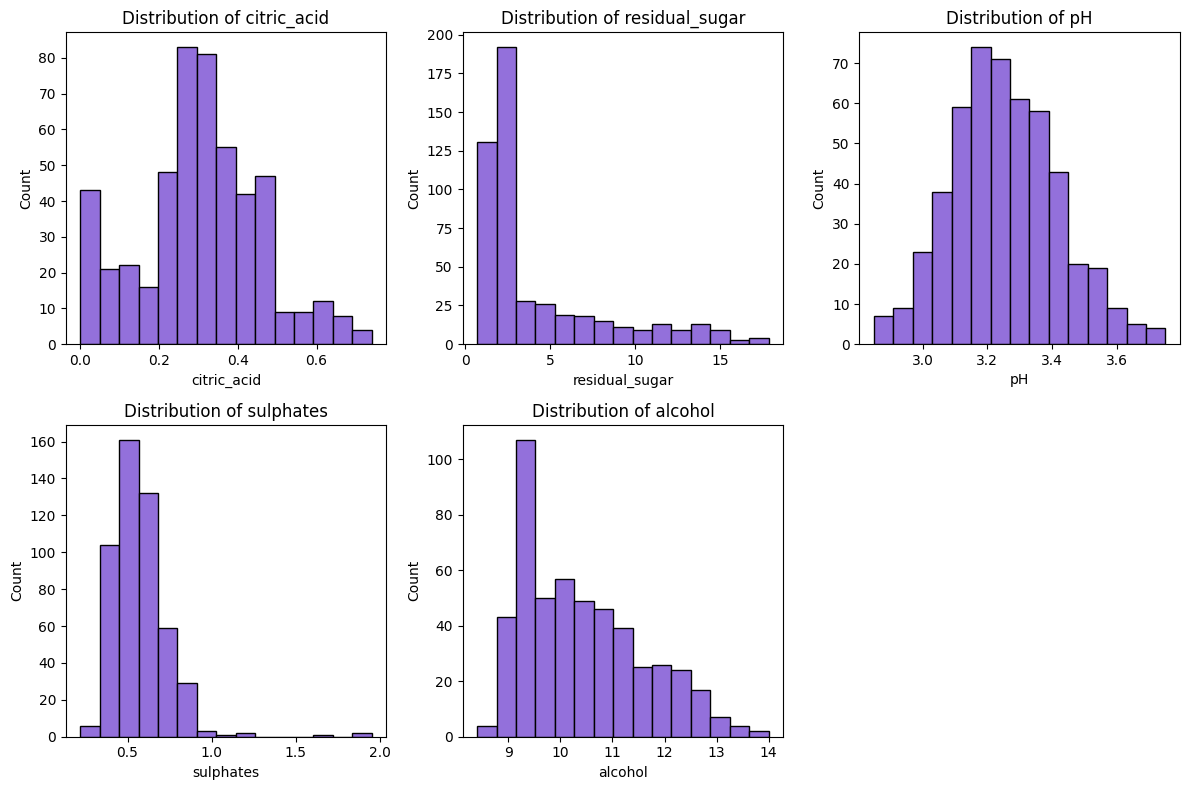

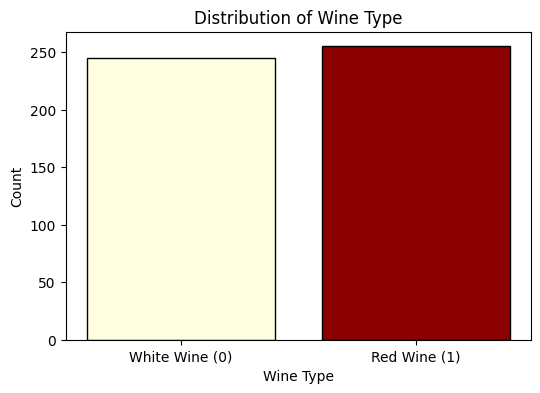

In [33]:
# Convert data to a structured format for easier plotting
data_dict = {feature: X[:, i] for i, feature in enumerate(feature_names)}
data_dict['type'] = y

# Plot histograms for each feature
plt.figure(figsize=(12, 8))
for i, feature in enumerate(feature_names):
    plt.subplot(2, 3, i+1)
    plt.hist(data_dict[feature], bins=15, color='mediumpurple', edgecolor='black')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
plt.tight_layout()
plt.show()


# Colors and type labels for each wine type
colors = ['lightyellow', 'darkred']
types = ['White Wine (0)', 'Red Wine (1)']

# Create a bar plot for wine type distribution
wine_types, counts = np.unique(data_dict['type'], return_counts=True)

plt.figure(figsize=(6, 4))
plt.bar(wine_types, counts, color=colors, edgecolor='black')

# Add labels and title
plt.title('Distribution of Wine Type')
plt.xlabel('Wine Type')
plt.ylabel('Count')

# Add labels for wine types
plt.xticks([0, 1], types)

# Show the plot
plt.show()


Split the data into train and val, and test

In [34]:
from sklearn.model_selection import train_test_split

# Split the data, 70% for training&validation and 30% for test
X_train_and_val, X_test, y_train_and_val, y_test = train_test_split(X, y, test_size=0.3, random_state=seed, shuffle=True)

### Kfold
Use Kfold with 5 splits

In [35]:
from sklearn.model_selection import KFold

# Init KFold with 5 splits
kf = KFold(n_splits=5, shuffle=True, random_state=seed)

### Hyperparameters

Define hyperparameter values to test for the model tuning

In [36]:
## Hyperparameters
criterion_values = ["gini", "entropy"]

# Decision Tree
dt_max_depth_values = [3, 5, 8, 10, 12, 15, 25, None]

# Random Forest
rf_n_estimators_values = [5, 10, 15, 25, 50, 100]
rf_max_depth_values = [3, 5, 8, 10, 12, 15, 25, None]
rf_max_features_values = ["sqrt", "log2", None]

### Tuning the models

Defining a generic function for tuning both Decision Tree and Random Forest (self & sklearn)

In [37]:
def tune_hyperparameters(model_class: DecisionTree | DecisionTreeClassifier | RandomForest | RandomForestClassifier, parameter_grid):
    # Seed for deterministic output
    #np.random.seed(seed)

    best_accuracy = 0
    best_hyperparameters = {}

    for params in parameter_grid:
        accuracies = []
        
        # Perform k-fold cross-validation
        for train_index, val_index in kf.split(X_train_and_val):
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]

            model = model_class(**params)

            # Train the decision tree self (train on root)
            if isinstance(model, DecisionTree):
                model.root = model.fit(X_train, y_train)
            else:
                # Train like normal
                model.fit(X_train, y_train)
                        
            # Make predictions on the validation fold
            y_pred = model.predict(X_val)
            
            # Compute accuracy
            accuracy = accuracy_score(y_val, y_pred)
            accuracies.append(accuracy)
        
        # Calculate the mean accuracy across all folds
        mean_accuracy = np.mean(accuracies)
        
        # Only keep the best accuracy and hyperparameters
        if mean_accuracy > best_accuracy:
            best_accuracy = mean_accuracy
            best_hyperparameters = params
    
    return best_hyperparameters, best_accuracy


Tuning the self made Decision Tree on the validation set to get the optimal hyperparameters

In [38]:
# Tune the Decision Tree
dt_param_grid = [
    {'max_depth': md, 'criterion': c, 'random_state': seed}
    for md in dt_max_depth_values
    for c in criterion_values
    ]

best_hyperparameters_dt_self, best_accuracy_dt_self = tune_hyperparameters(DecisionTree, dt_param_grid)
best_hyperparameters_dt_sklearn, best_accuracy_dt_sklearn = tune_hyperparameters(DecisionTreeClassifier, dt_param_grid)


print(f"Best Desicion Tree Accuracy (self): {best_accuracy_dt_self}")
print(f"Best Desicion Tree Parameters (self): {best_hyperparameters_dt_self}")
print()
print(f"Best Desicion Tree Accuracy (sklearn): {best_accuracy_dt_sklearn}")
print(f"Best Desicion Tree Parameters (sklearn): {best_hyperparameters_dt_sklearn}")

Best Desicion Tree Accuracy (self): 0.7742857142857142
Best Desicion Tree Parameters (self): {'max_depth': 5, 'criterion': 'gini', 'random_state': 0}

Best Desicion Tree Accuracy (sklearn): 0.8342857142857143
Best Desicion Tree Parameters (sklearn): {'max_depth': 10, 'criterion': 'gini', 'random_state': 0}


Best Desicion Tree Accuracy (self): 0.7742857142857142
Best Desicion Tree Parameters (self): {'max_depth': 5, 'criterion': 'gini', 'random_state': 0}

Best Desicion Tree Accuracy (sklearn): 0.8342857142857143
Best Desicion Tree Parameters (sklearn): {'max_depth': 10, 'criterion': 'gini', 'random_state': 0}

Tuning the self made Random Forest on the validation set to get the optimal hyperparameters

In [39]:
# Tune the Random Forest
rf_param_grid = [
    {'n_estimators': ne, 'max_depth': md, 'max_features': mf, 'criterion': c, 'random_state': seed} 
    for ne in rf_n_estimators_values 
    for md in rf_max_depth_values 
    for mf in rf_max_features_values 
    for c in criterion_values
]

best_hyperparameters_rf_self, best_accuracy_rf_self = tune_hyperparameters(RandomForest, rf_param_grid)
best_hyperparameters_rf_sklearn, best_accuracy_rf_sklearn = tune_hyperparameters(RandomForestClassifier, rf_param_grid)

print(f"Best Random Forest Accuracy (self): {best_accuracy_rf_self}")
print(f"Best Random Forest Parameters (self): {best_hyperparameters_rf_self}")
print()
print(f"Best Random Forest Accuracy (sklearn): {best_accuracy_rf_sklearn}")
print(f"Best Random Forest Parameters (sklearn): {best_hyperparameters_rf_sklearn}")

Best Random Forest Accuracy (self): 0.7742857142857142
Best Random Forest Parameters (self): {'n_estimators': 5, 'max_depth': 8, 'max_features': None, 'criterion': 'entropy', 'random_state': 0}

Best Random Forest Accuracy (sklearn): 0.8742857142857142
Best Random Forest Parameters (sklearn): {'n_estimators': 100, 'max_depth': 12, 'max_features': None, 'criterion': 'gini', 'random_state': 0}


Best Random Forest Accuracy (self): 0.7742857142857142
Best Random Forest Parameters (self): {'n_estimators': 5, 'max_depth': 8, 'max_features': None, 'criterion': 'entropy', 'random_state': 0}


Best Random Forest Accuracy (sklearn): 0.8742857142857142
Best Random Forest Parameters (sklearn): {'n_estimators': 100, 'max_depth': 12, 'max_features': None, 'criterion': 'gini', 'random_state': 0}






### Evaluating the results

Defining a generic function for evaluating both Decision Tree and Random Forest (self & sklearn)

In [40]:
# Evaluate model function => Train and test the best models
def evaluate_model(model_class, params):
    model = model_class(**params)
    if isinstance(model, DecisionTree):
        model.root = model.fit(X_train_and_val, y_train_and_val)
    else:
        model.fit(X_train_and_val, y_train_and_val)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

Train RandomForest and DecisionTree to the best hyperparameters, and check the accuracy of the models to the test set

In [41]:
print(f"Test accuracy DT (self): {evaluate_model(DecisionTree, best_hyperparameters_dt_self)}")
print(f"Test accuracy DT (sklearn): {evaluate_model(DecisionTreeClassifier, best_hyperparameters_dt_sklearn)}")
print(f"Test accuracy RF (self): {evaluate_model(RandomForest, best_hyperparameters_rf_self)}")
print(f"Test accuracy RF (sklearn): {evaluate_model(RandomForestClassifier, best_hyperparameters_rf_sklearn)}")


Test accuracy DT (self): 0.8
Test accuracy DT (sklearn): 0.84
Test accuracy RF (self): 0.72
Test accuracy RF (sklearn): 0.8866666666666667


Test accuracy DT (self): 0.8
Test accuracy DT (sklearn): 0.84
Test accuracy RF (self): 0.72
Test accuracy RF (sklearn): 0.8866666666666667

#### Compare the results of the models

In [42]:
def print_comparison_results(best_hyperparameters_dt_self, best_accuracy_dt_self, best_hyperparameters_dt_sklearn, best_accuracy_dt_sklearn, 
                             best_hyperparameters_rf_self, best_accuracy_rf_self, best_hyperparameters_rf_sklearn, best_accuracy_rf_sklearn,
                             ):
    
    num_equality_signs = 150
    
    print("="*num_equality_signs)
    print(f"{'Model':<40}{'Best Hyperparameters':<40}{'CV Accuracy':<15}{'Test Accuracy':<15}")
    print("="*num_equality_signs)
    
    # Decision Tree (self)
    dt_self_test_acc = evaluate_model(DecisionTree, best_hyperparameters_dt_self)
    print(f"{'Decision Tree (self)':<40}{str(best_hyperparameters_dt_self):<40}{best_accuracy_dt_self:<15.4f}{dt_self_test_acc:<15.4f}")
    print()
    
    # Decision Tree (sklearn)
    dt_sklearn_test_acc = evaluate_model(DecisionTreeClassifier, best_hyperparameters_dt_sklearn)
    print(f"{'Decision Tree (sklearn)':<40}{str(best_hyperparameters_dt_sklearn):<40}{best_accuracy_dt_sklearn:<15.4f}{dt_sklearn_test_acc:<15.4f}")
    print()

    # Random Forest (self)
    rf_self_test_acc = evaluate_model(RandomForest, best_hyperparameters_rf_self)
    print(f"{'Random Forest (self)':<40}{str(best_hyperparameters_rf_self):<40}{best_accuracy_rf_self:<15.4f}{rf_self_test_acc:<15.4f}")
    print()

    # Random Forest (sklearn)
    rf_sklearn_test_acc = evaluate_model(RandomForestClassifier, best_hyperparameters_rf_sklearn)
    print(f"{'Random Forest (sklearn)':<40}{str(best_hyperparameters_rf_sklearn):<40}{best_accuracy_rf_sklearn:<15.4f}{rf_sklearn_test_acc:<15.4f}")
    
    print("="*num_equality_signs)

In [43]:
# Call the print function to compare results
print_comparison_results(best_hyperparameters_dt_self, best_accuracy_dt_self, best_hyperparameters_dt_sklearn, best_accuracy_dt_sklearn, 
                         best_hyperparameters_rf_self, best_accuracy_rf_self, best_hyperparameters_rf_sklearn, best_accuracy_rf_sklearn,
                         )

Model                                   Best Hyperparameters                    CV Accuracy    Test Accuracy  
Decision Tree (self)                    {'max_depth': 5, 'criterion': 'gini', 'random_state': 0}0.7743         0.8000         

Decision Tree (sklearn)                 {'max_depth': 10, 'criterion': 'gini', 'random_state': 0}0.8343         0.8400         

Random Forest (self)                    {'n_estimators': 5, 'max_depth': 8, 'max_features': None, 'criterion': 'entropy', 'random_state': 0}0.7743         0.7200         

Random Forest (sklearn)                 {'n_estimators': 100, 'max_depth': 12, 'max_features': None, 'criterion': 'gini', 'random_state': 0}0.8743         0.8867         


======================================================================================================================================================
Model                                   Best Hyperparameters                    CV Accuracy    Test Accuracy  
======================================================================================================================================================
Decision Tree (self)                    {'max_depth': 5, 'criterion': 'gini', 'random_state': 0}0.7743         0.8000         

Decision Tree (sklearn)                 {'max_depth': 10, 'criterion': 'gini', 'random_state': 0}0.8343         0.8400         

Random Forest (self)                    {'n_estimators': 5, 'max_depth': 8, 'max_features': None, 'criterion': 'entropy', 'random_state': 0}0.7743         0.7200         

Random Forest (sklearn)                 {'n_estimators': 100, 'max_depth': 12, 'max_features': None, 'criterion': 'gini', 'random_state': 0}0.8743         0.8867         
======================================================================================================================================================

### 3.3

## Dataset (Coffee)

In [44]:
data = np.genfromtxt("../coffee_data.csv", delimiter=",", dtype=float, names=True)

feature_names = list(data.dtype.names[:-1])
target_name = data.dtype.names[-1]

X = np.array([data[feature] for feature in feature_names]).T
y = data[target_name].astype(int)

# Print size of data
print(f"Feature columns names: {feature_names}")
print(f"Target column name: {target_name}")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

Feature columns names: ['Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body', 'Balance', 'Uniformity', 'Sweetness']
Target column name: CountryofOrigin
X shape: (419, 8)
y shape: (419,)


Plot Coffee Dataset

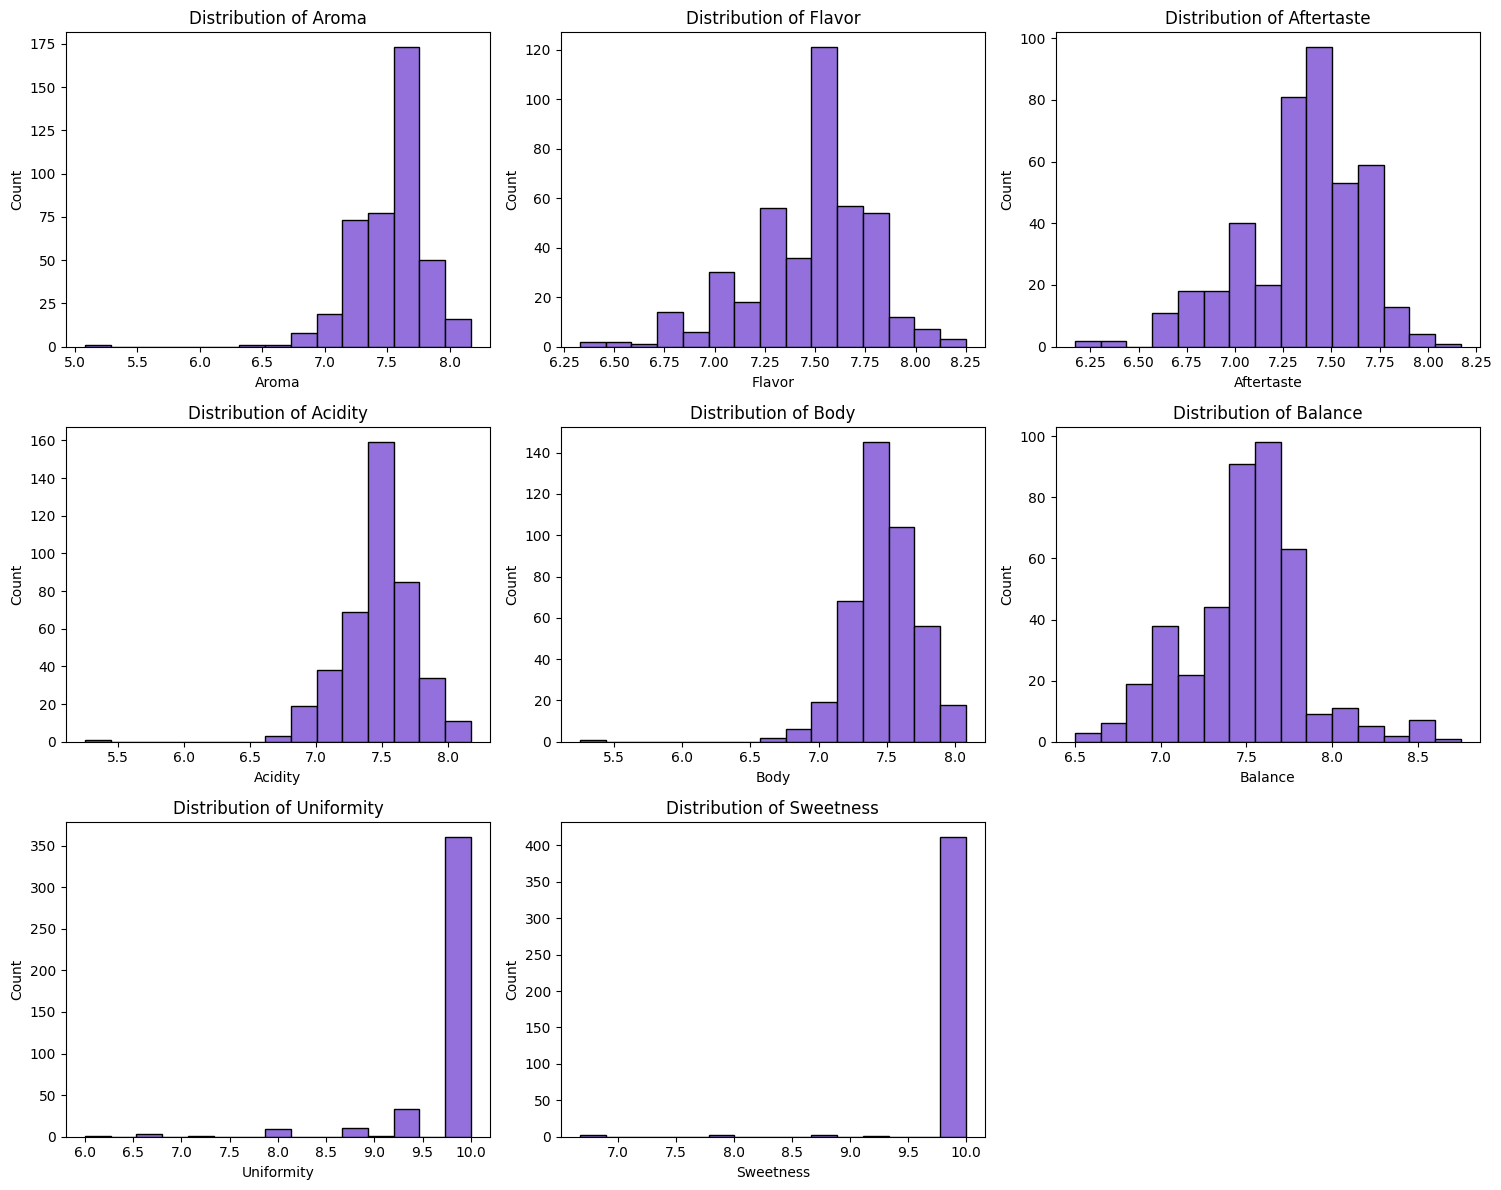

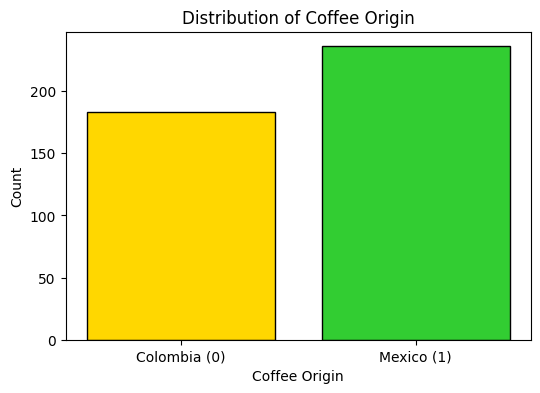

In [45]:
# Convert data to a structured format for easier plotting
data_dict = {feature: X[:, i] for i, feature in enumerate(feature_names)}
data_dict[target_name] = y  # Ensure the target is correctly added

# Plot histograms for each feature
num_features = len(feature_names)
cols = 3  # Number of columns in subplot grid
rows = (num_features + cols - 1) // cols  # Calculate number of rows needed

plt.figure(figsize=(cols * 5, rows * 4))
for i, feature in enumerate(feature_names):
    plt.subplot(rows, cols, i + 1)
    plt.hist(data_dict[feature], bins=15, color='mediumpurple', edgecolor='black')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Colors and type labels for each coffee origin
colors = ['gold', 'limegreen']
types = ['Colombia (0)', 'Mexico (1)']

# Create a bar plot for coffee origin distribution
coffee_origin, counts = np.unique(data_dict[target_name], return_counts=True)

plt.figure(figsize=(6, 4))
plt.bar(coffee_origin, counts, color=colors, edgecolor='black')

# Add labels and title
plt.title('Distribution of Coffee Origin')
plt.xlabel('Coffee Origin')
plt.ylabel('Count')

# Add labels for coffee origins
plt.xticks(coffee_origin, types)

# Show the plot
plt.show()

Split the data into train and val, and test

In [46]:
from sklearn.model_selection import train_test_split

# Split the data, 70% for training&validation and 30% for test
X_train_and_val, X_test, y_train_and_val, y_test = train_test_split(X, y, test_size=0.3, random_state=seed, shuffle=True)

### Tuning the models

In [47]:
# Tune the Decision Tree
best_hyperparameters_dt_self, best_accuracy_dt_self = tune_hyperparameters(DecisionTree, dt_param_grid)
best_hyperparameters_dt_sklearn, best_accuracy_dt_sklearn = tune_hyperparameters(DecisionTreeClassifier, dt_param_grid)


print(f"Best Desicion Tree Accuracy (self): {best_accuracy_dt_self}")
print(f"Best Desicion Tree Parameters (self): {best_hyperparameters_dt_self}")
print()
print(f"Best Desicion Tree Accuracy (sklearn): {best_accuracy_dt_sklearn}")
print(f"Best Desicion Tree Parameters (sklearn): {best_hyperparameters_dt_sklearn}")

Best Desicion Tree Accuracy (self): 0.7473991817650497
Best Desicion Tree Parameters (self): {'max_depth': 3, 'criterion': 'gini', 'random_state': 0}

Best Desicion Tree Accuracy (sklearn): 0.7682641729982466
Best Desicion Tree Parameters (sklearn): {'max_depth': 5, 'criterion': 'entropy', 'random_state': 0}


Best Desicion Tree Accuracy (self): 0.7473991817650497
Best Desicion Tree Parameters (self): {'max_depth': 3, 'criterion': 'gini', 'random_state': 0}

Best Desicion Tree Accuracy (sklearn): 0.7682641729982466
Best Desicion Tree Parameters (sklearn): {'max_depth': 5, 'criterion': 'entropy', 'random_state': 0}

In [48]:
# Tune the Random Forest
best_hyperparameters_rf_self, best_accuracy_rf_self = tune_hyperparameters(RandomForest, rf_param_grid)
best_hyperparameters_rf_sklearn, best_accuracy_rf_sklearn = tune_hyperparameters(RandomForestClassifier, rf_param_grid)

print(f"Best Random Forest Accuracy (self): {best_accuracy_rf_self}")
print(f"Best Random Forest Parameters (self): {best_hyperparameters_rf_self}")
print()
print(f"Best Random Forest Accuracy (sklearn): {best_accuracy_rf_sklearn}")
print(f"Best Random Forest Parameters (sklearn): {best_hyperparameters_rf_sklearn}")

Best Random Forest Accuracy (self): 0.7407364114552892
Best Random Forest Parameters (self): {'n_estimators': 5, 'max_depth': 5, 'max_features': None, 'criterion': 'entropy', 'random_state': 0}

Best Random Forest Accuracy (sklearn): 0.7952659263588544
Best Random Forest Parameters (sklearn): {'n_estimators': 100, 'max_depth': 3, 'max_features': 'log2', 'criterion': 'gini', 'random_state': 0}


Best Random Forest Accuracy (self): 0.7407364114552892
Best Random Forest Parameters (self): {'n_estimators': 5, 'max_depth': 5, 'max_features': None, 'criterion': 'entropy', 'random_state': 0}

Best Random Forest Accuracy (sklearn): 0.7952659263588544
Best Random Forest Parameters (sklearn): {'n_estimators': 100, 'max_depth': 3, 'max_features': 'log2', 'criterion': 'gini', 'random_state': 0}

### Evaluating the results

In [49]:
print(f"Test accuracy DT (self): {evaluate_model(DecisionTree, best_hyperparameters_dt_self)}")
print(f"Test accuracy DT (sklearn): {evaluate_model(DecisionTreeClassifier, best_hyperparameters_dt_sklearn)}")
print(f"Test accuracy RF (self): {evaluate_model(RandomForest, best_hyperparameters_rf_self)}")
print(f"Test accuracy RF (sklearn): {evaluate_model(RandomForestClassifier, best_hyperparameters_rf_sklearn)}")

Test accuracy DT (self): 0.7698412698412699
Test accuracy DT (sklearn): 0.8253968253968254
Test accuracy RF (self): 0.7619047619047619
Test accuracy RF (sklearn): 0.8809523809523809


Test accuracy DT (self): 0.7698412698412699
Test accuracy DT (sklearn): 0.8253968253968254
Test accuracy RF (self): 0.7619047619047619
Test accuracy RF (sklearn): 0.8809523809523809

In [50]:
# Call the print function to compare results
print_comparison_results(best_hyperparameters_dt_self, best_accuracy_dt_self, best_hyperparameters_dt_sklearn, best_accuracy_dt_sklearn, 
                         best_hyperparameters_rf_self, best_accuracy_rf_self, best_hyperparameters_rf_sklearn, best_accuracy_rf_sklearn,
                         )

Model                                   Best Hyperparameters                    CV Accuracy    Test Accuracy  
Decision Tree (self)                    {'max_depth': 3, 'criterion': 'gini', 'random_state': 0}0.7474         0.7698         

Decision Tree (sklearn)                 {'max_depth': 5, 'criterion': 'entropy', 'random_state': 0}0.7683         0.8254         

Random Forest (self)                    {'n_estimators': 5, 'max_depth': 5, 'max_features': None, 'criterion': 'entropy', 'random_state': 0}0.7407         0.7619         

Random Forest (sklearn)                 {'n_estimators': 100, 'max_depth': 3, 'max_features': 'log2', 'criterion': 'gini', 'random_state': 0}0.7953         0.8810         


======================================================================================================================================================
Model                                   Best Hyperparameters                    CV Accuracy    Test Accuracy  
======================================================================================================================================================
Decision Tree (self)                    {'max_depth': 3, 'criterion': 'gini', 'random_state': 0}0.7474         0.7698         

Decision Tree (sklearn)                 {'max_depth': 5, 'criterion': 'entropy', 'random_state': 0}0.7683         0.8254         

Random Forest (self)                    {'n_estimators': 5, 'max_depth': 5, 'max_features': None, 'criterion': 'entropy', 'random_state': 0}0.7407         0.7619         

Random Forest (sklearn)                 {'n_estimators': 100, 'max_depth': 3, 'max_features': 'log2', 'criterion': 'gini', 'random_state': 0}0.7953         0.8810         
======================================================================================================================================================

....
